In [37]:
#from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Assuming the Excel file is named 'data.xlsx' and located in the current directory
file_path ="EAH_Database_all.xlsx"
df = pd.read_excel(file_path)

#replacing any statistical outliers with mean values
outlier_cols=[
       'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g','v1_freddy_pre_eah']

In [38]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)

{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 1, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 1, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0}


In [39]:
def remove_subjects_with_outliers(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Filter out rows where outliers exist in the specified columns
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Usage
outlier_cols = ['mvpa_simple_avg']
df = remove_subjects_with_outliers(df, outlier_cols)

In [40]:
# Filtering the dataset for subjects with actual values in the specified columns
filtered_df = df.dropna(subset=['mvpa_simple_avg'])

# Printing the first few rows of the filtered dataset to confirm
print(filtered_df[['mvpa_simple_avg']].head())

# You can also get the count of remaining subjects
remaining_subjects_count = filtered_df.shape[0]
print(f"Number of subjects with actual values: {remaining_subjects_count}")

   mvpa_simple_avg
0       354.722222
1       484.027778
2       473.333333
5       396.366667
6       478.571429
Number of subjects with actual values: 66


In [41]:
df_no_outliers=filtered_df.copy()

# Moderation by median split of PA (%mvpa and total mvpa, averaged), risk status : EAH_sweet_kcal

In [42]:
import pandas as pd

# df_no_outliers is your DataFrame
mean_sd_stats = df_no_outliers[['mvpa_simple_avg']].agg(['mean', 'std', 'min', 'max'])

# Formatting the output to two decimal places
mean_sd_stats = mean_sd_stats.map(lambda x: f"{x:.2f}")

print(mean_sd_stats)

     mvpa_simple_avg
mean          430.40
std            67.28
min           240.71
max           575.74


In [43]:
# Perform the median split on 'Total MVPA'
median_total_mvpa = df_no_outliers['mvpa_simple_avg'].median()
df_no_outliers['median_split_total_mvpa'] = np.where(df_no_outliers['mvpa_simple_avg'] > median_total_mvpa, 1, 0)

In [44]:
# Define a function to get the statistics
def get_group_stats(df, group_col, target_col):
    stats = df.groupby(group_col)[target_col].agg(['count', 'mean', 'std']).reset_index()
    return stats

# Calculate statistics for 'Total MVPA'
total_mvpa_stats = get_group_stats(df_no_outliers, 'median_split_total_mvpa', 'mvpa_simple_avg')
total_mvpa_stats.columns = ['Group (Total MVPA)', 'Count', 'Mean (Total MVPA)', 'Std (Total MVPA)']


# Formatting the output to two decimal places
total_mvpa_stats[['Mean (Total MVPA)', 'Std (Total MVPA)']] = total_mvpa_stats[['Mean (Total MVPA)', 'Std (Total MVPA)']].map(lambda x: f"{x:.2f}")

# Print the results
print("Total MVPA Stats:")
print(total_mvpa_stats)


Total MVPA Stats:
   Group (Total MVPA)  Count Mean (Total MVPA) Std (Total MVPA)
0                   0     33            377.29            45.98
1                   1     33            483.52            35.52


In [45]:
from scipy.stats import ttest_ind
# Columns to test
columns_to_test = [
    'v1_eah_kcal', 'v1_meal_kcal', 'v1_eah_sweet_kcal', 'v1_eah_sav_kcal', 'v1_eah_g', 'v1_meal_g', 
    'v1_eah_sweet_g', 'v1_eah_sav_g', 'v7_eah_kcal', 'v7_meal_kcal', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal', 
    'v7_eah_g', 'v7_meal_g', 'v7_eah_sweet_g', 'v7_eah_sav_g'
]

# Function to perform t-tests and collect results
def perform_ttests(df, group_col, test_cols):
    results = []
    group1 = df[df[group_col] == 0]
    group2 = df[df[group_col] == 1]
    
    for col in test_cols:
        t_stat, p_val = ttest_ind(group1[col], group2[col], nan_policy='omit')
        mean1, mean2 = group1[col].mean(), group2[col].mean()
        sd1, sd2 = group1[col].std(), group2[col].std()
        range1, range2 = (group1[col].min(), group1[col].max()), (group2[col].min(), group2[col].max())
        n1, n2 = group1[col].count(), group2[col].count()
        results.append({
            'Variable': col, 
            't-Statistic': t_stat, 
            'p-Value': p_val,
            'Group1_Mean': mean1, 
            'Group2_Mean': mean2,
            'Group1_SD': sd1, 
            'Group2_SD': sd2,
            'Group1_Range': range1, 
            'Group2_Range': range2,
            'Group1_N': n1, 
            'Group2_N': n2
        })
    
    return pd.DataFrame(results)

# Perform t-tests
ttest_results = perform_ttests(df_no_outliers, 'median_split_total_mvpa', columns_to_test)

# Print results
print(ttest_results)

# Optional: Display results in a more readable format
with pd.option_context('display.max_columns', None):
    display(ttest_results)


             Variable  t-Statistic   p-Value  Group1_Mean  Group2_Mean  \
0         v1_eah_kcal    -0.808654  0.421710   259.640212   286.026327   
1        v1_meal_kcal     0.971721  0.334848   604.281280   539.698735   
2   v1_eah_sweet_kcal    -1.005279  0.318548   236.928163   268.127572   
3     v1_eah_sav_kcal    -0.453721  0.651564    22.712049    26.371472   
4            v1_eah_g    -1.040830  0.301870   106.449697   124.936190   
5           v1_meal_g     1.287374  0.202600   337.725135   285.689983   
6      v1_eah_sweet_g    -1.209931  0.230756    61.942121    70.947830   
7        v1_eah_sav_g    -0.505839  0.614707     4.402727     5.189545   
8         v7_eah_kcal    -0.091009  0.927770   295.951936   299.221973   
9        v7_meal_kcal     0.190612  0.849433   697.394345   685.540877   
10  v7_eah_sweet_kcal    -0.455689  0.650156   265.073069   281.139627   
11    v7_eah_sav_kcal     1.335292  0.186511    24.156328    15.141879   
12           v7_eah_g     0.725777  0.

,Variable,t-Statistic,p-Value,Group1_Mean,Group2_Mean,Group1_SD,Group2_SD,Group1_Range,Group2_Range,Group1_N,Group2_N
0,v1_eah_kcal,-0.808654,0.421710,259.640212,286.026327,121.728156,142.538373,"(60.37430999999995, 569.6712999999997)","(95.58554999999998, 642.05487)",33,33
1,v1_meal_kcal,0.971721,0.334848,604.281280,539.698735,258.640631,280.842834,"(219.67092000000005, 1125.12447)","(55.81333999999999, 1200.1792999999998)",33,33
2,v1_eah_sweet_kcal,-1.005279,0.318548,236.928163,268.127572,116.717033,134.769946,"(42.74560000000001, 552.9737)","(57.967650000000006, 564.9226100000002)",33,33
3,v1_eah_sav_kcal,-0.453721,0.651564,22.712049,26.371472,26.762536,37.820838,"(0.0, 112.22032999999996)","(0.0, 175.64742999999993)",33,33
4,v1_eah_g,-1.040830,0.301870,106.449697,124.936190,63.742694,79.669103,"(14.810000000000002, 285.84000000000003)","(26.649999999999977, 348.28999999999996)",33,33
5,v1_meal_g,1.287374,0.202600,337.725135,285.689983,183.527756,142.236310,"(68.17000000000002, 679.2000000000002)","(76.76, 599.5600000000002)",33,33
6,v1_eah_sweet_g,-1.209931,0.230756,61.942121,70.947830,26.793791,33.321375,"(10.650000000000006, 121.78999999999999)","(15.390000000000015, 142.35000000000002)",33,33
7,v1_eah_sav_g,-0.505839,0.614707,4.402727,5.189545,5.145184,7.305496,"(0.0, 22.03)","(0.0, 34.609999999999985)",33,33
8,v7_eah_kcal,-0.091009,0.927770,295.951936,299.221973,139.351969,152.266304,"(68.94812999999999, 665.39691)","(0.0, 634.5846399999998)",33,33
9,v7_meal_kcal,0.190612,0.849433,697.394345,685.540877,231.785042,271.830304,"(265.7185500000002, 1142.0594700000001)","(0.0, 1311.7205899999997)",33,33


In [46]:
# Standardize the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_columns = ['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']
df_no_outliers[scaled_columns] = scaler.fit_transform(df_no_outliers[scaled_columns])

# Save the original scaled data for plotting
df_unscaled = df_no_outliers.copy()


# Inverse transform the scaled variables for plotting
df_unscaled[['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']] = scaler.inverse_transform(df_unscaled[scaled_columns])

In [47]:
# Recoding the income column
df_no_outliers['income'] = df_no_outliers['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_no_outliers['parent_ed'] = df_no_outliers['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

In [48]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_no_outliers['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_no_outliers.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_no_outliers = pd.concat([df_no_outliers, tanner_dummies], axis=1)

In [49]:
# Fit regression models
model_total_mvpa_meal_kcal= smf.ols('v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff +avg_wear_time +v1_meal_kcal * median_split_total_mvpa', data=df_no_outliers).fit()
# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_meal_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     24.17
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.66e-17
Time:                        16:04:55   Log-Likelihood:                -32.024
No. Observations:                  66   AIC:                             90.05
Df Residuals:                      53   BIC:                             118.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [50]:
# Fit regression models
model_total_mvpa_eah_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_kcal*median_split_total_mvpa', data=df_no_outliers).fit()

# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_eah_kcal.summary())


Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     27.87
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.16e-18
Time:                        16:04:55   Log-Likelihood:                -28.002
No. Observations:                  66   AIC:                             82.00
Df Residuals:                      53   BIC:                             110.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [51]:
# Fit regression models
model_total_mvpa_eah_sweet_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal*median_split_total_mvpa', data=df_no_outliers).fit()
# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_eah_sweet_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     28.10
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.72e-19
Time:                        16:04:55   Log-Likelihood:                -27.771
No. Observations:                  66   AIC:                             81.54
Df Residuals:                      53   BIC:                             110.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [52]:
# Fit regression models
model_total_mvpa_eah_sav_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sav_kcal*median_split_total_mvpa', data=df_no_outliers).fit()
# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_eah_sav_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     24.52
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.95e-17
Time:                        16:04:55   Log-Likelihood:                -31.623
No. Observations:                  66   AIC:                             89.25
Df Residuals:                      53   BIC:                             117.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

# Graphs

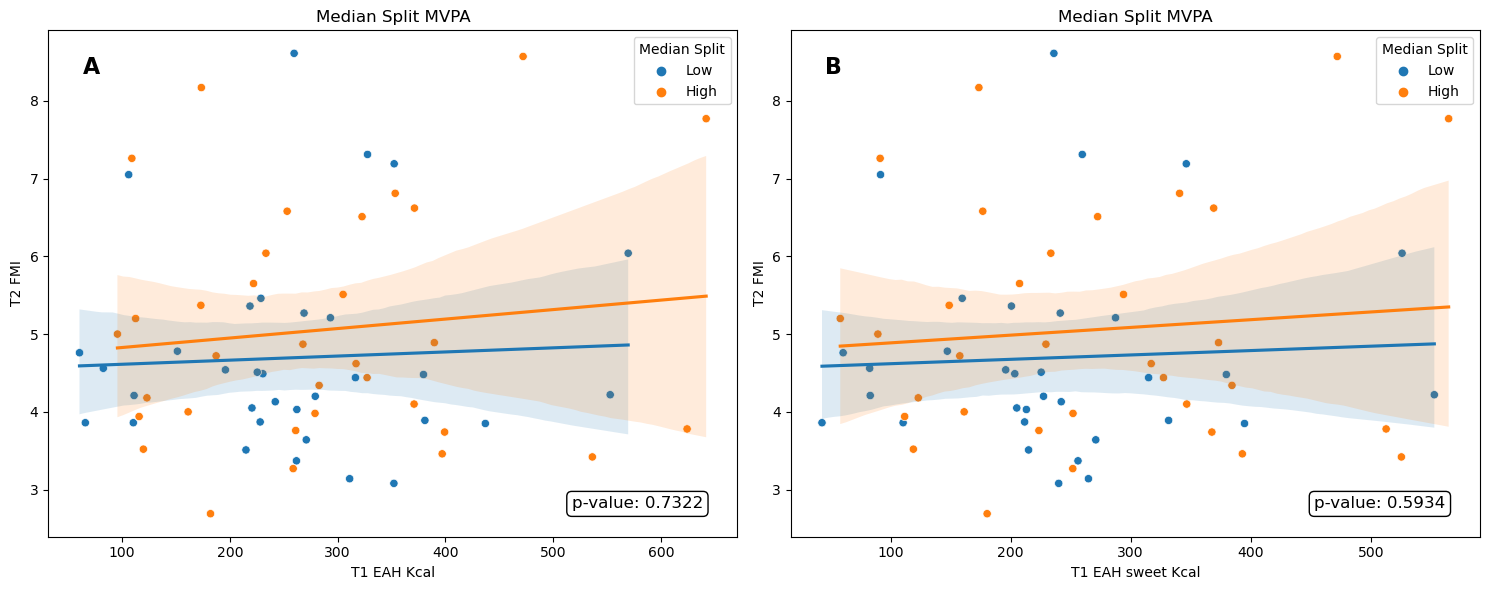

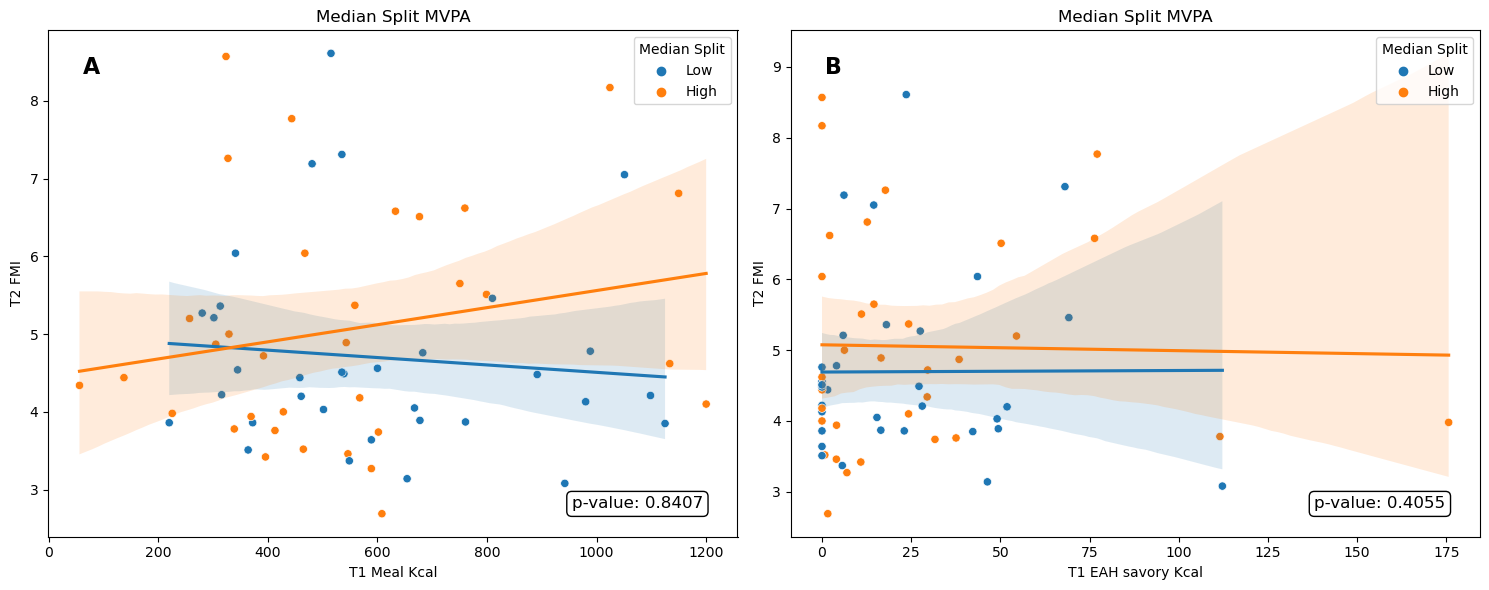

In [53]:
# Map the median split values to 'Low' and 'High'
df_unscaled['median_split_total_mvpa'] = df_unscaled['median_split_total_mvpa'].map({0: 'Low', 1: 'High'})

# Extract the p-values
p_values = {
    'v1_eah_sweet_kcal*median_split_total_mvpa': model_total_mvpa_eah_sweet_kcal.pvalues['v1_eah_sweet_kcal:median_split_total_mvpa'],
    'v1_eah_sav_kcal*median_split_total_mvpa': model_total_mvpa_eah_sav_kcal.pvalues['v1_eah_sav_kcal:median_split_total_mvpa'],
    'v1_eah_kcal*median_split_total_mvpa': model_total_mvpa_eah_kcal.pvalues['v1_eah_kcal:median_split_total_mvpa'],
    'v1_meal_kcal*median_split_total_mvpa': model_total_mvpa_meal_kcal.pvalues['v1_meal_kcal:median_split_total_mvpa'],
}

# Create subplots for EAH and EAH sweet (2x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_eah = ['A', 'B']

# Plotting function to add scatter and regression plots with p-value
def plot_with_regression_and_pvalue(x, y, hue, data, ax, xlabel, ylabel, title, label, pvalue):
    scatter = sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    for hue_level in data[hue].unique():
        sns.regplot(x=x, y=y, data=data[data[hue] == hue_level], ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
    ax.text(0.95, 0.05, f"p-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    handles, labels = scatter.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=['Low', 'High'], title='Median Split', loc='upper right')

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_total_mvpa', df_unscaled, axes1[0], 'T1 EAH Kcal', 'T2 FMI', 'Median Split MVPA', labels_eah[0], p_values['v1_eah_kcal*median_split_total_mvpa'])

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_total_mvpa', df_unscaled, axes1[1], 'T1 EAH sweet Kcal', 'T2 FMI', 'Median Split MVPA', labels_eah[1], p_values['v1_eah_sweet_kcal*median_split_total_mvpa'])

plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (2x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_meal = ['A', 'B']

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_total_mvpa', df_unscaled, axes2[0], 'T1 Meal Kcal', 'T2 FMI', 'Median Split MVPA', labels_meal[0], p_values['v1_meal_kcal*median_split_total_mvpa'])

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_total_mvpa', df_unscaled, axes2[1], 'T1 EAH savory Kcal', 'T2 FMI', 'Median Split MVPA', labels_meal[1], p_values['v1_eah_sav_kcal*median_split_total_mvpa'])

plt.tight_layout()
plt.show()


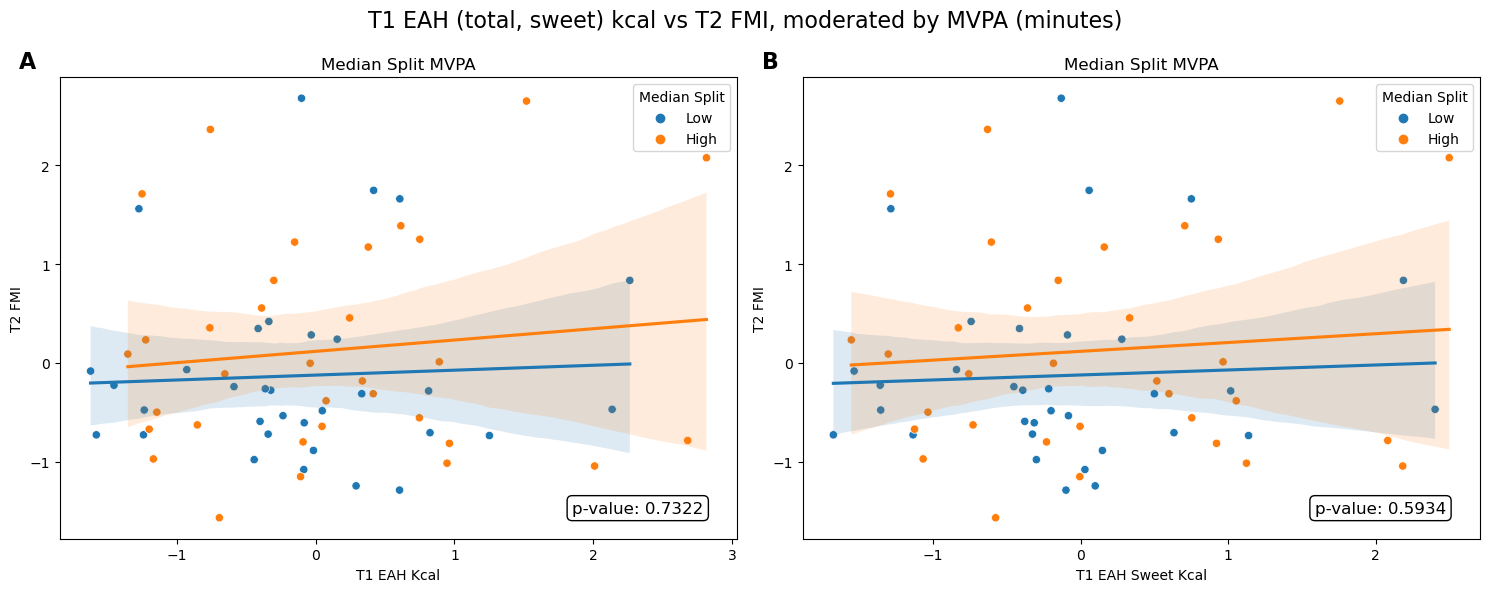

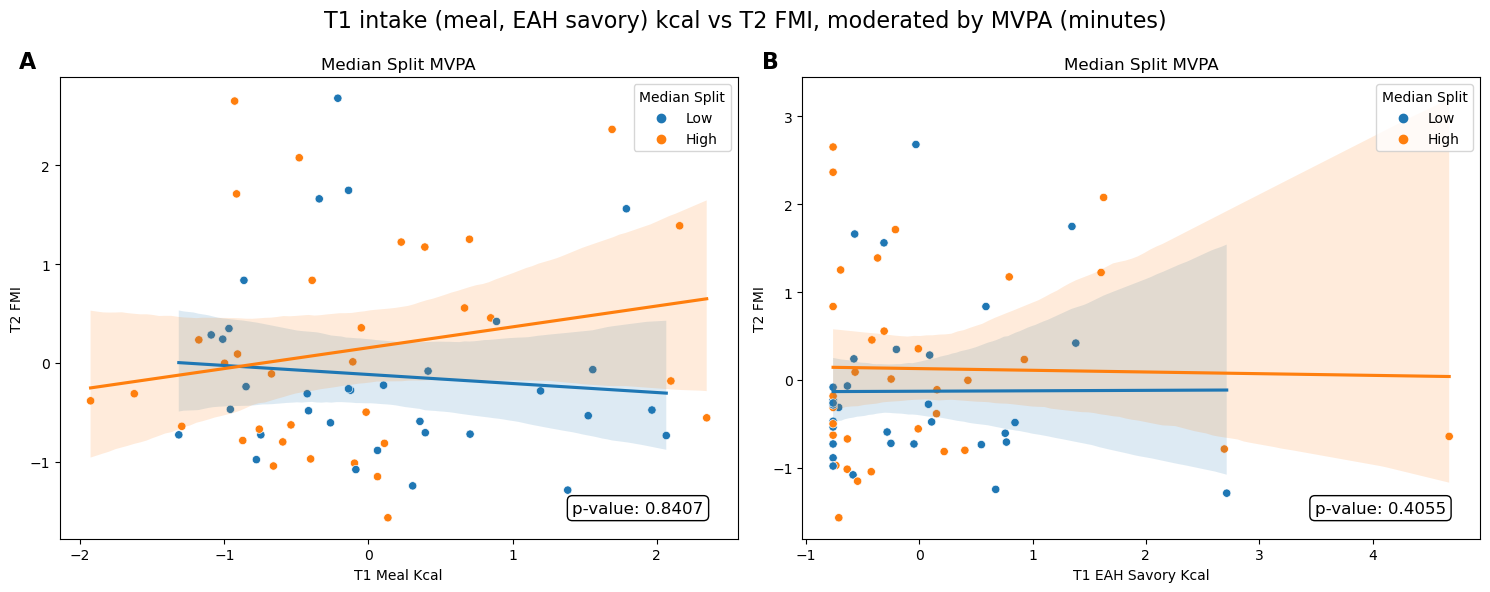

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the plotting function to add scatter and regression plots with p-value
def plot_with_regression_and_pvalue(x, y, hue, data, ax, xlabel, ylabel, title, pvalue):
    scatter = sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    for hue_level in data[hue].unique():
        sns.regplot(x=x, y=y, data=data[data[hue] == hue_level], ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.95, 0.05, f"p-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    handles, labels = scatter.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=['Low', 'High'], title='Median Split', loc='upper right')

# Create subplots for EAH and EAH sweet (1x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_total_mvpa', df_no_outliers, axes1[0], 
                                'T1 EAH Kcal', 'T2 FMI', 'Median Split MVPA', p_values['v1_eah_kcal*median_split_total_mvpa'])
axes1[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_total_mvpa', df_no_outliers, axes1[1], 
                                'T1 EAH Sweet Kcal', 'T2 FMI', 'Median Split MVPA', p_values['v1_eah_sweet_kcal*median_split_total_mvpa'])
axes1[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.suptitle("T1 EAH (total, sweet) kcal vs T2 FMI, moderated by MVPA (minutes)", fontsize=16)
plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (1x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_total_mvpa', df_no_outliers, axes2[0], 
                                'T1 Meal Kcal', 'T2 FMI', 'Median Split MVPA', p_values['v1_meal_kcal*median_split_total_mvpa'])
axes2[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_total_mvpa', df_no_outliers, axes2[1], 
                                'T1 EAH Savory Kcal', 'T2 FMI', 'Median Split MVPA', p_values['v1_eah_sav_kcal*median_split_total_mvpa'])
axes2[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.suptitle("T1 intake (meal, EAH savory) kcal vs T2 FMI, moderated by MVPA (minutes)", fontsize=16)
plt.tight_layout()
plt.show()
